# Getting Started with Affinity

This notebook gives useful examples on how to make use of the Affinity endpoints in the Signal AI API.

Full technical documentation of the Affinity endpoints are available here
https://api.signal-ai.com/docs#tag/Concept-Affinity


## What is Affinity?


The Signal platform processes a huge amount of unstructured data (text) every day, and it further helps parse the data by adding meaningful classifications (entities, topics, sentiment). By doing this, we allow our users to access useful **relevant information**, for example articles about their brand. Indeed the Search endpoints of the Signal AI API allows you to do exactly that.

Taking the platform to the next level, we built **the Signal AI knowledge graph** - a powerful structure to represent connections between entities and topics and how they change over time. With this knowledge graph and through the **Affinity** capabilities in the API, you will be able to ask questions about the data and find unknowns.

To give an idea, here are examples of questions that you  will be able to answer with the Affinity endpoints: 

a. What are currently the top topics associated with my brand (in media)? Is Sustainability one of them?

b. How is the conversation changing around a certain company? Are there any risky topics associated with it?


## 0. Setting things up!

### 0.1 Pre-requesites

Please make sure that you have familiarised yourself with the Signal AI API using the [Getting Started with the Search API notebook](getting_started.ipynb)

In particular you would need to be able to use the following endpoints:

1- Authentication: to be able to access the API

2- Discovery: to be able to search for entities and topics of interest

Note: run `pip install -r requirements.txt` to install the dependencies for this notebook

In [27]:
import backoff
import requests
import os
import pandas as pd

### 0.2 Check if authentication works! 

You will need a client_id and client_secret to gain access to the API. The code below will assume they have been set and the environment variables SIGNAL_API_CLIENT_ID and SIGNAL_API_CLIENT_SECRET respectively.

Using your credentials you can request a temporary access token from the API using the url:
https://api.signal-ai.com/auth/token

In [18]:
def authenticate(client_id, client_secret, url = "https://api.signal-ai.com"):
    """ obtain a temporary access token using user credentials """
    token_url = f'{url}/auth/token'
    payload = {
        "grant_type": "client_credentials",
        "client_id": client_id,
        "client_secret": client_secret
    }
    response = requests.post(token_url, data=payload)
    return response.json().get("access_token")

In [106]:
TEMP_ACCESS_TOKEN = authenticate(os.environ['SIGNAL_API_CLIENT_ID'], os.environ['SIGNAL_API_CLIENT_SECRET'])
if TEMP_ACCESS_TOKEN:
    print('Congratulations! You have an access token, it will last for 24 hours before you will need to reauthenticate by repeating this step')
else:
    print('Error: Perhaps the credentials are incorrect?')

Congratulations! You have an access token, it will last for 24 hours before you will need to reauthenticate by repeating this step


## Using Affinity

The affinity endpoints allows API users to leverage the power of the Signal AI knowledge graph that we construct from our content and update over time.

In the following we give examples on useful questions that can be answered with this knolwedge graph.

## 1. Proximity Examples

### 1.1 Entities most associated with a topic (at a certain time)

Example use case:
- Who are currently the main active organisations within a certain industry? Are there new players in the market?  Is there a rising competition? 



How: 
Using the Affinity end points, rank organisation by their proximity score to a topic.

Note that you would need to have the ID of the topic as an input. For that please consult [Getting Started notebook](getting_started.ipynb) to search for topics and obtain the ID

**Example**: top 20 organisations in the Wearables industry in December 2020

In [19]:
last_month = (pd.to_datetime("today").to_period('M') - 1).strftime('%Y-%m')
topic_id = 'f861d9df-5a65-41fe-8077-1714b838f1e1' ## topic ID for Wearables
response = requests.post(
    # call the entities endpoint
    'https://api.signal-ai.com/affinity',
    json={
        'source-concept': {
            'id': topic_id
        },
        'relationship': {
            'type': 'proximity',
            'date': {
                'start': last_month,
                'end': last_month
            },
            'interval': 'month',
            'limit-per-interval': 20
        },
        'target-concepts': {
            'types': ['entity/organisation']
        }
    },
    # include the access token in the header
    headers={
        "Authorization": f'Bearer {TEMP_ACCESS_TOKEN}',
        "Content-Type": "application/json",
    }
)

result = response.json()


In [20]:
df = pd.json_normalize(result['results'])
df[['target-concept.name']]

,target-concept.name
0,Garmin
1,Fitbit
2,Fossil Group
3,Apple Inc.
4,Epix (TV channel)
5,TAG Heuer
6,Huawei
7,Google
8,Consumer Technology Association
9,CES 2022


### 1.2 Topics most associated with an entity (at a certain time)

Example use case:
- What are currently the top topics associated with my brand (in media)? Is Sustainability one of them?

How: using the Affinity end points, rank topics by their proximity score to a certain organisation, also retrieve the scores to generate a visualisation


**Example**: top 10 topics associated to Tesla, Inc. in December 2020

In [6]:
entity_id = '11cab8df-4be1-470f-8f49-8f7f0863ec95' ##  ID for Tesla, Inc.
response = requests.post(
    # call the entities endpoint
    'https://api.signal-ai.com/affinity',
    json={
        'source-concept': {
            'id': entity_id
        },
        'relationship': {
            'type': 'proximity',
            'date': {
                'start': last_month,
                'end': last_month
            },
            'interval': 'month',
            'limit-per-interval': 10
        }
    },
    # include the access token in the header
    headers={
        "Authorization": f'Bearer {TEMP_ACCESS_TOKEN}',
        "Content-Type": "application/json",
    }
)

result = response.json()

In [17]:
df = pd.json_normalize(result['results'])
df[['target-concept.name']]

,target-concept.name
0,Electric Vehicles (EV)
1,Futures of Transport
2,Cleantech
3,Touch Free Technology
4,Automotive Industry
5,Autonomous Vehicles
6,Corporate Controversy
7,Transport
8,Executive Compensation
9,Sustainability


### 1.3 Changes of associations over time

Example use case:
- How is the conversation changing around a certain company? Are they any emerging risks?

How: Using the Affinity endpoints, identify the top topics by proximity to a certain organisation over time



**Example**: How is the conversation changing about 'Wirecard' between fifteen to thirteen months ago

In [21]:
fifteen_months_ago = (pd.to_datetime("today").to_period('M') - 15)
fourteen_months_ago = fifteen_months_ago + 1
thirteen_months_ago = fifteen_months_ago + 2
entity_id = 'eae834b7-5b2f-430e-99ce-770786a971cf' ##  ID for Wirecard
response = requests.post(
    # call the entities endpoint
    'https://api.signal-ai.com/affinity',
    json={
        'source-concept': {
            'id': entity_id
        },
        'relationship': {
            'type': 'proximity',
            'date': {
                'start': fifteen_months_ago.strftime('%Y-%m'),
                'end': thirteen_months_ago.strftime('%Y-%m')
            },
            'interval': 'month',
            'limit-per-interval': 100
        }
    },
    # include the access token in the header
    headers={
        "Authorization": f'Bearer {TEMP_ACCESS_TOKEN}',
        "Content-Type": "application/json",
    }
)
if response.status_code == 200:
    result = response.json()
else:
    raise Exception(f"Got bad status code from API: {response.status_code}")

The results now contain the montly proximities so we can now see changes over time

In [24]:
df = pd.json_normalize(result['results'])
df_sep = df[df['relationship.date']==fifteen_months_ago.strftime('%Y-%m')]
df_sep.head(10)[['target-concept.name','relationship.date', 'relationship.proximity-score']]

,target-concept.name,relationship.date,relationship.proximity-score
0,Workplace Malpractice,2020-11,0.489803
1,Bankruptcy,2020-11,0.474146
2,Accounting Irregularities,2020-11,0.473428
3,Corporate Bankruptcy,2020-11,0.450672
4,Corporate Crisis,2020-11,0.434548
5,Insolvency,2020-11,0.392665
6,Internal Controls Application,2020-11,0.387548
7,Corporate Controversy,2020-11,0.371417
8,Corrupt Fraud,2020-11,0.357408
9,Financial Crime,2020-11,0.348068


In [25]:
df = pd.json_normalize(result['results'])
df_14_months_ago = df[df['relationship.date']==fourteen_months_ago.strftime('%Y-%m')]
df_14_months_ago.head(10)[['target-concept.name','relationship.date', 'relationship.proximity-score']]

,target-concept.name,relationship.date,relationship.proximity-score
65,Workplace Malpractice,2020-12,0.459743
66,Bankruptcy,2020-12,0.430488
67,Accounting Irregularities,2020-12,0.415869
68,Corporate Crisis,2020-12,0.414661
69,Internal Controls Application,2020-12,0.388031
70,Corporate Controversy,2020-12,0.332393
71,Anti-Money-Laundering,2020-12,0.326444
72,Financial Crime,2020-12,0.319449
73,Integrity in the Workplace,2020-12,0.315191
74,Corrupt Fraud,2020-12,0.314541


In [26]:
df = pd.json_normalize(result['results'])
df_13_months_ago = df[df['relationship.date']==thirteen_months_ago.strftime('%Y-%m')]
df_13_months_ago.head(10)[['target-concept.name','relationship.date', 'relationship.proximity-score']]

,target-concept.name,relationship.date,relationship.proximity-score
139,Workplace Malpractice,2021-01,0.471875
140,Corporate Crisis,2021-01,0.413944
141,Bankruptcy,2021-01,0.407329
142,Anti-Money-Laundering,2021-01,0.357370
143,Financial Regulation,2021-01,0.354112
144,Accounting Irregularities,2021-01,0.332014
145,Internal Controls Application,2021-01,0.330750
146,Corrupt Fraud,2021-01,0.329328
147,Financial Crime,2021-01,0.327794
148,Corporate Controversy,2021-01,0.306428


We can observe here that some topics popped up in October and November which were not there, such 'Accounting Irregularities' and 'Corporate crisis' which can be risk indicators. 

In [48]:
df

,relationship.date,relationship.type,relationship.proximity-score,relationship.sentiment-score,target-concept.id,target-concept.name,target-concept.type
0,2020-11,proximity,0.489803,-0.316580,e68a3f5e-8dcb-4775-8eab-dad92fafd137,Workplace Malpractice,topic
1,2020-11,proximity,0.474146,-0.075669,cd4e3e70-0623-43ae-9068-7c11e43fef32,Bankruptcy,topic
2,2020-11,proximity,0.473428,-0.285714,3546f963-3f94-4853-8914-e516f9b8c4d9,Accounting Irregularities,topic
3,2020-11,proximity,0.450672,0.248945,5339186c-3440-4186-a74b-051eae85e000,Corporate Bankruptcy,topic
4,2020-11,proximity,0.434548,-0.351572,dccd7fba-6c5f-4087-b8a0-0178c559b95e,Corporate Crisis,topic
...,...,...,...,...,...,...,...
202,2021-01,proximity,0.017509,-0.111111,ee1b80a4-0378-47c7-b92f-c8d430559c68,Hacking,topic
203,2021-01,proximity,0.016509,0.343137,1addb6d9-6d12-41a8-b2b8-281e678bee65,Securitisation,topic
204,2021-01,proximity,0.009949,0.650000,3d60bf39-b795-4113-a833-9dad1306a03e,"TMT (technology, media, telecoms)",topic
205,2021-01,proximity,0.008445,0.476190,b0488453-5a2c-4ffd-a3c0-f697212d5dc3,Asset Finance,topic


### 1.4 Comparing associations over time

Example use case:
- Over the past year, how do certain organisations compare with regards to their association with a certain topic?

**Example**: How do these car manufacturers: Mercedez-Benz, General Motors, Tesla Inc. compare  with regards to their association to the ‘Product Recall’ topic?

In [49]:
topic_id = '734a342f-a053-4823-9bda-8abb687182ba' ##  ID for Product Recall
response = requests.post(
    # call the entities endpoint
    'https://api.signal-ai.com/affinity',
    json={
        'source-concept': {
            'id': topic_id
        },
        'relationship': {
            'type': 'proximity',
            'date': {
                'start': '2020-01',
                'end': '2020-12'
            },
            'interval': 'month'
        },
        'target-concepts': {
            'ids': [
                '8d9ee12f-f4f2-3dc7-a8b9-673a07bd7747', # Mercedez-Benz 
                'a9cf01c5-751f-4fe5-a529-12e0d297cb63', # General Motors
                '11cab8df-4be1-470f-8f49-8f7f0863ec95', # Tesla
            ]
        }
    },
    # include the access token in the header
    headers={
        "Authorization": f'Bearer {TEMP_ACCESS_TOKEN}',
        "Content-Type": "application/json",
    }
)

result = response.json()

In [50]:
df = pd.json_normalize(result['results'])


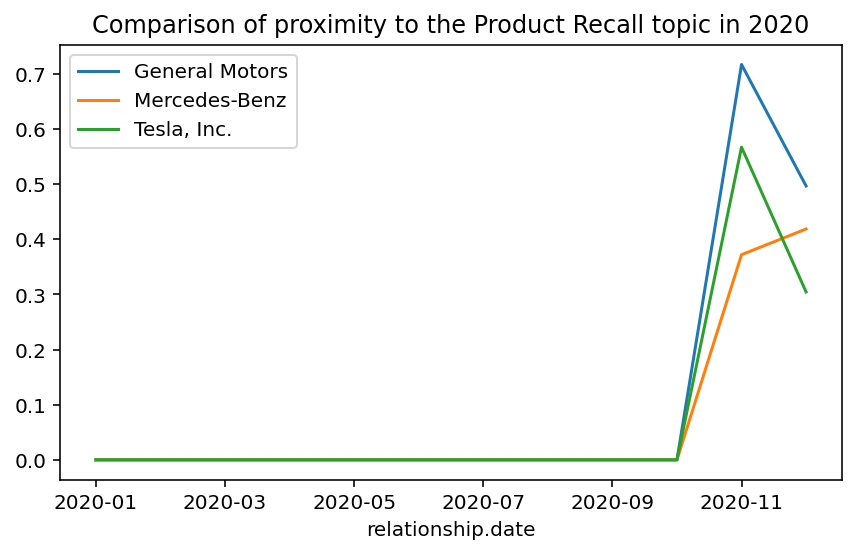

In [ ]:
# plot the proximity over time for the three car manufacturers
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=[7,4], dpi=144, facecolor='w')
ax1 = plt.subplot(111)
groupedby_company = df.groupby('target-concept.name')
plot=groupedby_company.plot(kind='line', x='relationship.date', y='relationship.proximity-score', ax = ax1)
groups = [group for group,_ in groupedby_company]
ax1.legend(groups)
_ = ax1.set_title('Comparison of proximity to the Product Recall topic in 2020')

The plot shows clearly that Tesla overall is less associated to product recall throughout 2020, though we can see an exception around October, where there is a clear spike.

To explain this spike we can rely on the search endpoints on the API by retrieving the most relevant articles that mention Tesla and Product Recall

In [ ]:
# the query to search for Tesla Inc. and Product Recall in October 2020
query = {
    'where': {
        "published-at": {"gte": "2020-10-01", "lt": "2020-10-31"},
        'topics': {
            'id': {
                # id for the environment topic found using the dicovery endpoints
                'eq': '734a342f-a053-4823-9bda-8abb687182ba'
            },
        },
        'entities':{
            'id' : {
                'eq':'11cab8df-4be1-470f-8f49-8f7f0863ec95'
            },
            'salient-only': True
        }
    },
    'size': 10,
    'sort': [['score','desc']], # sort by relevance to get the most relevant 10 articles
}

response = requests.post(
    'https://api.signal-ai.com/search',
    json=query,
    headers={
        "Authorization": f'Bearer {TEMP_ACCESS_TOKEN}',
        "Content-Type": "application/json",
    }
)
results = response.json()

In [ ]:
# Get the top 10 headlines on this
for i, document in enumerate(results['documents']):
    print('{}) {} {}'.format(i+1, document['published-at'].split('T')[0], document['title']))

These headlines explain this high proximity in October. It is because of Tesla recalling thousands of vehicles in China